# Initial analysis

A first look at the received data from CBS


### Initialization
Initialization of the libraries and csv or excel data files

In [1]:
import urllib.request as urllib, os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

filename = '10k_chunk_1_c.csv'
datafolder = '../Data/Cleaned_data/'

try:
    os.mkdir(datafolder)
except FileExistsError:
    pass

data = pd.read_csv(datafolder + filename, delimiter=';')

### Cleaning
After the initialization a cleaning and possibly enriching process will be performed to make the data usable. 

In [2]:
def count_missing(x):
  return sum(x.isnull())
print("Missing values per column:")
print(data.apply(count_missing, axis=0))

Missing values per column:
Unnamed: 0             0
Unnamed: 0.1           0
datum                  0
url                    0
sentiment              0
discussielengte        0
views                  0
auteur                 0
GPS breedtegraad    3888
GPS lengtegraad     3888
bericht tekst         14
likes count            0
datum utc              0
hashtags             223
dtype: int64


### Pie chart

In this pie chart is an overview of the sentiment of all the posts

Neutral:  5111
Positive:  3128
Negative:  177


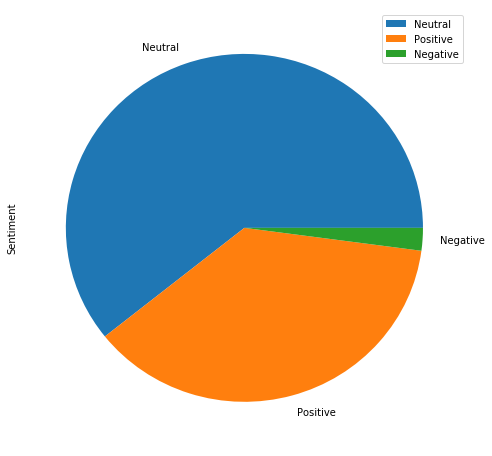

In [3]:
# Sentiment neutral
print('Neutral: ', len(data.loc[data['sentiment']=='0']))

# Sentiment positive
print('Positive: ', len(data.loc[data['sentiment'] == '+']))

# Sentiment negative
print('Negative: ', len(data.loc[data['sentiment'] == '-']))

# Pie chart
pd.DataFrame({'Sentiment': [len(data.loc[data['sentiment'] == '0']), 
                          len(data.loc[data['sentiment'] == '+']),
                          len(data.loc[data['sentiment'] == '-'])]}, index=['Neutral', 'Positive', 'Negative']).plot.pie(y='Sentiment', figsize=(8,8))



### Bar chart

In these chart are the 20 most viewed posts (top chart) with its length of discussion (bottom chart)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002917A96E828>,
      dtype=object)

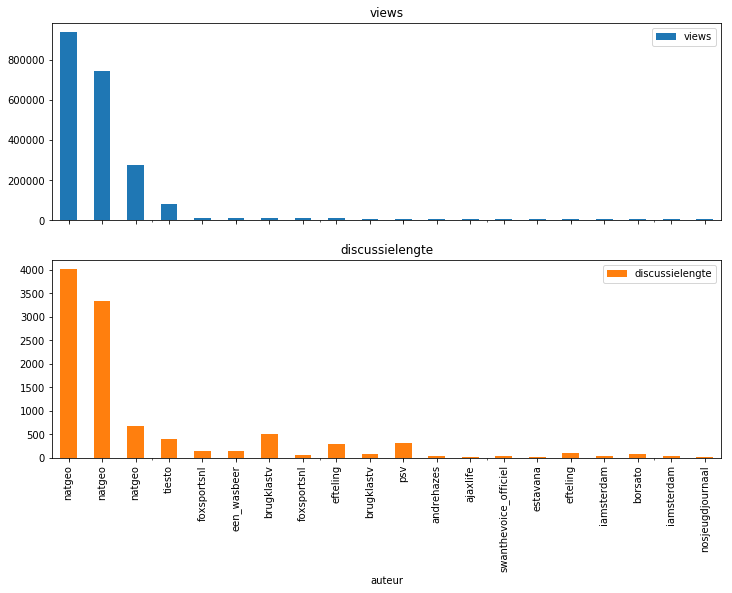

In [4]:
data.sort_values(by='views', ascending=False).head(20)\
    .plot.bar(x='auteur', y=['views', 'discussielengte'], rot=90, subplots=True, figsize=(12,8))

### Scatter chart
In this scatter chart are the locations of the posts plotted. The color of the point represents the amount of views the post has

Within The Netherlands: 4359 of 8416


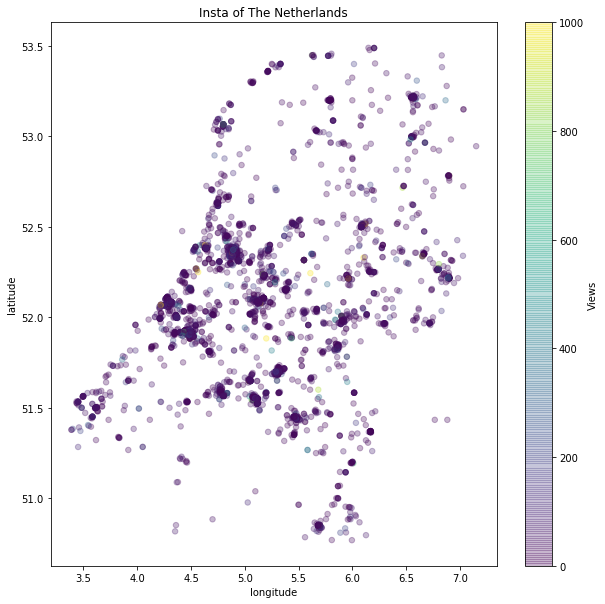

In [5]:
data_gps = data
data_gps = data_gps.loc[3.2 <= data_gps['GPS lengtegraad']]
data_gps = data_gps.loc[7.4 >= data_gps['GPS lengtegraad']]
data_gps = data_gps.loc[50.7 <= data_gps['GPS breedtegraad']]
data_gps = data_gps.loc[53.6 >= data_gps['GPS breedtegraad']]

plt.figure(figsize=[10,10]);

plt.title('Insta of The Netherlands')
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.xlim(3.2,7.4)
#plt.ylim(50.7,53.6)
sizes = 120

print('Within The Netherlands:', len(data_gps), 'of', len(data))

points=plt.scatter(data_gps['GPS lengtegraad'], data_gps['GPS breedtegraad'], marker='.'
                   , c=data_gps.views
                   , s=sizes**1
                   , alpha=0.3
                   , cmap='viridis')

plt.clim(0,1000)

plt.colorbar(label='Views');

### Interactive map
This generates a html file that has a interactive map where all the locations of the posts are.

In [6]:
#Use following command in prompt: pip install folium

import folium
 
# Make an empty map
m = folium.Map(location=[52.029247, 5.492443], tiles="OpenStreetMap", zoom_start=8)
 
#Add markers
for i in range(0,len(data)):
    if pd.notna(data.iloc[i]['GPS lengtegraad']):
        folium.Circle(
            location=[float(data.iloc[i]['GPS breedtegraad']), float(data.iloc[i]['GPS lengtegraad'])],
            popup=data.iloc[i]['url'],
            radius=10,
            color='crimson',
            fill=True,
            fill_color='crimson'
        ).add_to(m)
 
#Saves it as html
m.save('mymap.html')


### Line chart

This line chart represents the amount of post that are created in a specefied month

Text(0,0.5,'Number of posts')

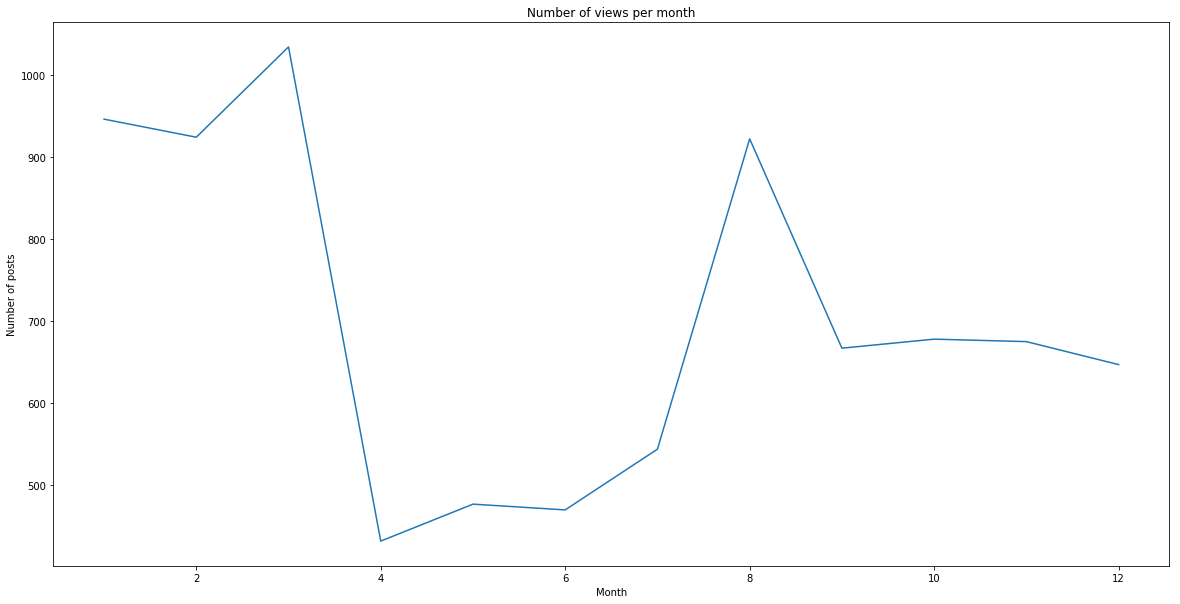

In [7]:
# Step 1: Convert to datetime
data['datum'] = pd.to_datetime(data['datum'], errors='coerce')
# Step 2: Make extra column with month number
data['Month'] = data['datum'].dt.month

data['Month'].value_counts().sort_index().plot(title='Number of views per month', \
                                               figsize=(20,10))
plt.xlabel('Month')
plt.ylabel('Number of posts')

We're gonna start with seeing how many times someone posts more than once. So this means that for example there could be three people who have posted 8 times. This would be represented as 8 -- 3

In [8]:
data.head(10)
x = data['auteur'].value_counts()
x.value_counts().sort_index()

# Plotting is not useful yet, more data needed
# plt.hist(x)
# plt.show()

1    7137
2     422
3      90
4      17
5      14
6       2
7       1
8       1
Name: auteur, dtype: int64

### Histogram
In this histogram the amount of posts are seen over time.

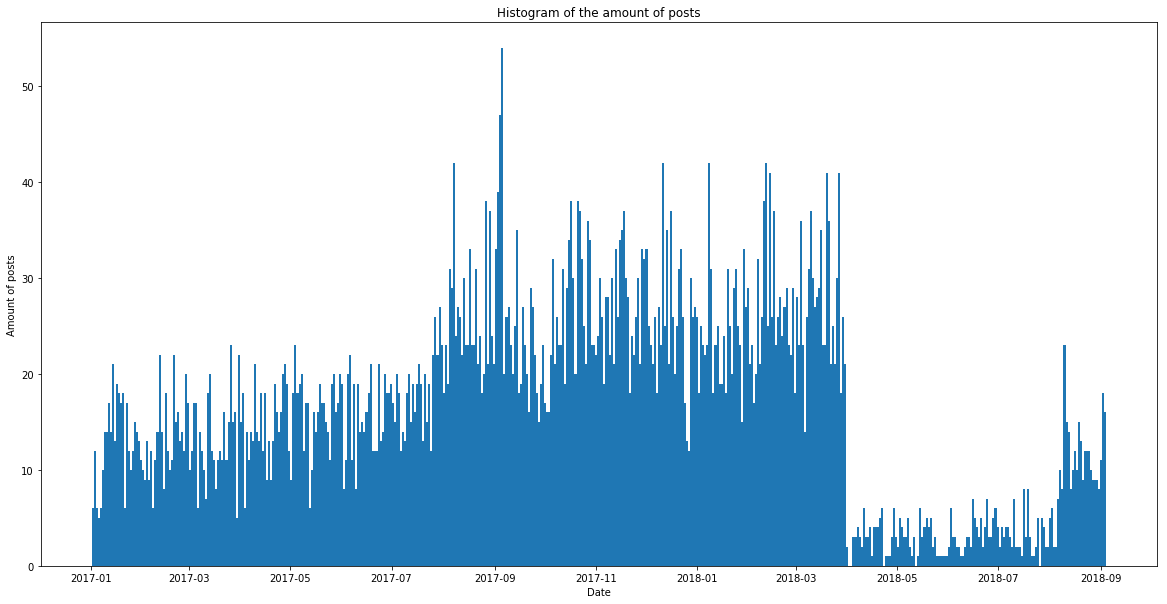

In [9]:
data['datum'] = data['datum'].astype("datetime64")

fig = plt.figure(figsize=(20,10))

bins = 500
plt.hist(data['datum'], bins=bins)

plt.xlabel('Date')
plt.ylabel('Amount of posts')
plt.title('Histogram of the amount of posts')
plt.show()

### Amount of hashtags within a post
This line represents how many post have a certain amount of hashtags

(0, 40)

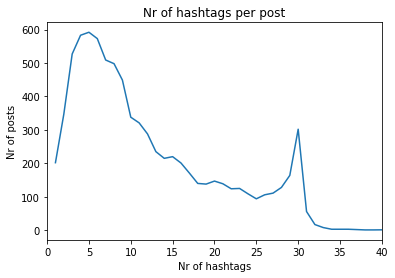

In [10]:
noh = []
for i in range(len(data.hashtags)):
    if pd.notna(data['hashtags'][i]):
        nr = len(data['hashtags'][i].split())
        noh.append(nr)
noh = pd.Series(noh)


plt.plot(noh.value_counts().sort_index())
plt.title('Nr of hashtags per post')
plt.ylabel('Nr of posts')
plt.xlabel('Nr of hashtags')
plt.xlim(0, 40)

### Creating our wordmap
Here we first setup our dictionary of dutch and english stopwords

In [11]:
with open('data/stopwords-nl.txt', 'r') as f:
    dict_nl = f.read().splitlines()
    dict_nl.extend(['aan']) # Add missing dutch words here

with open('data/stopwords-eng.txt', 'r') as f:
    dict_eng = f.read().splitlines()
    #dict_eng.extend(['']) # Add missing english words here
    
# Combine two dictionaries for easy use

dict_all = dict_nl
dict_all.extend(dict_eng)

Next up, we set up our Instagram image for later

In [12]:
from PIL import Image
mask = np.array(Image.open('data/Instagram_logo.png'))

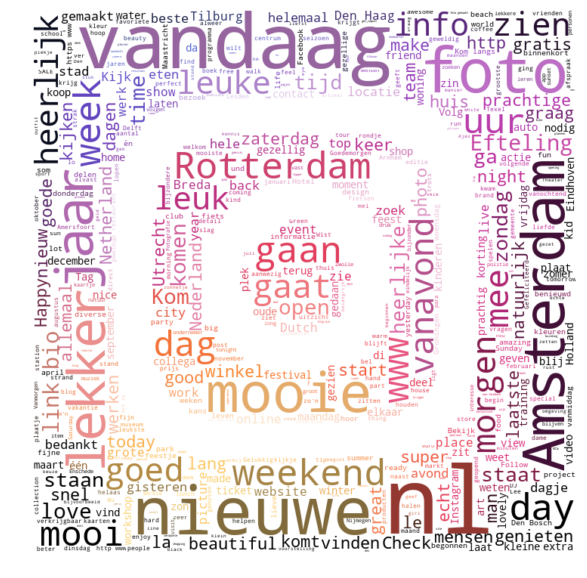

In [13]:
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords

cloud = WordCloud(background_color="white", max_words=500, stopwords=dict_all, mask=mask)

image_colors = ImageColorGenerator(mask)
positive_cloud = cloud.generate(data['bericht tekst'].str.cat(sep='\n'))
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

### Hashtag wordmap
Next we make a wordmap of all the hashtags

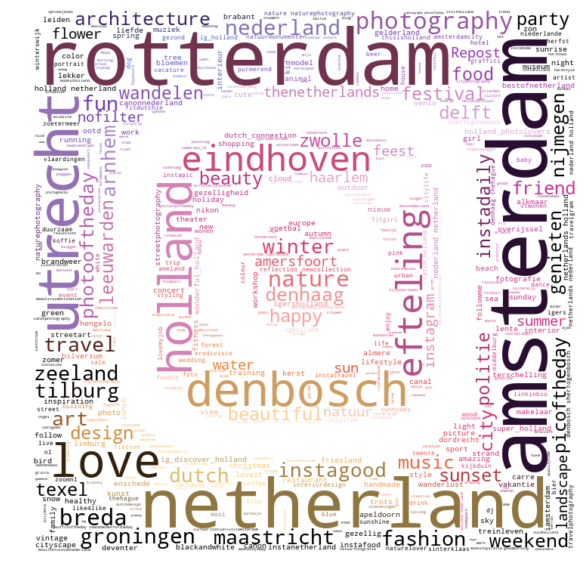

In [14]:
cloud = WordCloud(background_color="white", max_words=500, mask=mask)
image_colors = ImageColorGenerator(mask)

positive_cloud = cloud.generate(data['hashtags'].str.cat(sep='\n'))
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

### Wordmap (all)
This is the wordmap of the messages and the hashtags combined

In this wordmap we wanted to display a combination of all words used in the description and hastags combined. 

In [15]:
words_complete = data['bericht tekst'].str.cat(sep='\n') + data['hashtags'].str.cat(sep='\n')

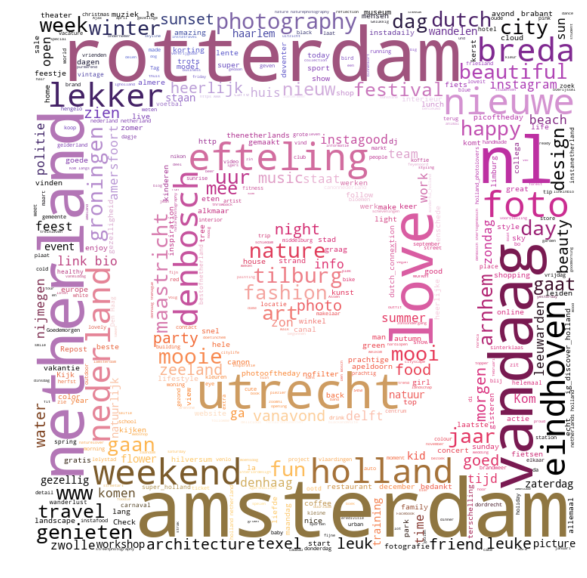

In [16]:
cloud = WordCloud(background_color="white", max_words=500, stopwords=dict_all, mask=mask)

image_colors = ImageColorGenerator(mask)
positive_cloud = cloud.generate(words_complete)
plt.figure(figsize=(10,10))
plt.imshow(positive_cloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()